In [108]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [110]:
from torchvision.transforms.transforms import ToTensor
train_data = datasets.MNIST(root="data",train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root="data",train=False,download=True,transform=ToTensor())

In [95]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [96]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [97]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [98]:
print(train_data.targets.size())

torch.Size([60000])


<function matplotlib.pyplot.show(close=None, block=None)>

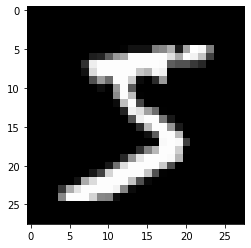

In [99]:
plt.imshow(train_data.data[0],cmap='gray')
plt.show

In [100]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2e4a45a6070>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2e4a45a6b80>}

In [101]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 10),
            nn.Softmax(),
                                 )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
             
        output = self.out(x)
        return output, x

In [102]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
    (2): Softmax(dim=None)
  )
)


In [103]:
cnn.load_state_dict(torch.load('/Content/FINALMODEL'))

FileNotFoundError: [Errno 2] No such file or directory: '/Content/FINALMODEL'

In [ ]:
optimizer = optim.Adam(cnn.parameters(),lr=0.001)
loss_function = nn.CrossEntropyLoss()
cnn = cnn.to(device)

In [ ]:
from torch.autograd import Variable
num_epochs = 15
def train(num_epochs, cnn, loaders):
  cnn.train()
        
  # Train the model
  total_step = len(loaders['train'])        
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(loaders['train']):
            
          
          b_x = images.to(device)
          b_y = labels.to(device)
          output = cnn(b_x)[0]               
          loss = loss_function(output, b_y)
            
            
          optimizer.zero_grad()           
            
            
          loss.backward()                          
          optimizer.step()                
            
          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))              
              pass
      pass
  pass
    
    
train(num_epochs, cnn, loaders)

In [104]:
cnn.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
    (2): Softmax(dim=None)
  )
)

In [105]:
def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [106]:
torch.save(cnn.state_dict(),'Content/FINALMODEL')

In [107]:
with torch.no_grad():
    n_correct=0
    n_samples=0
    for images,labels in loaders['test']:
        images = images.to(device)
        labels = labels.to(device)
        test_output1, last_layer = cnn(images)
        _,prediction=torch.max(test_output1,1)
        n_samples=labels.shape[0]
        n_correct=(prediction==labels).sum().item()
    accuracy=(n_correct/n_samples)*100

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
print(accuracy)

In [ ]:
cnn.load_state_dict('/Content/FINALMODEL')